## Predicting Controversiality of Comment Content

### Data Preprocessing:

### Select relevant variables
Choose relevant columns to do the predictive analysis


#### Handle Missing Values:
Check for missing values in the DataFrame and decide on a strategy for handling them, such as imputation or removal.


#### Convert Timestamp Variables:
Extract relevant features from timestamp variables like 'created_utc' and 'retrieved_on' (e.g., day of the week, hour of the day).


### Split the Data:

Split the DataFrame into training and testing sets to evaluate the model's performance.

### Build a Predictive Model:

#### Choose a Machine Learning Model:
Select a model suitable for predicting the target variable (controversiality). Common choices include decision trees, random forests, support vector machines, or gradient boosting algorithms.

#### Train the Model:
Use the training set to train the selected model.

### Model Evaluation:

Evaluate the model on the testing set using appropriate evaluation metrics such as accuracy, precision, recall, or F1 score.

#### Tune Hyperparameters:
Optimize the model's hyperparameters to improve performance.

### Interpret Results:

#### Analyze Predictions:
Examine the model's predictions and understand the importance of each feature in predicting controversiality.

#### Iterate and Improve:
Based on the results, refine the model or consider additional features to enhance predictive performance.


In [8]:
# Setup - Run only once per Kernel App
%conda install openjdk -y

# install PySpark
# install Python Reddit API Wrapper for getting external data Karma
%pip install pyspark==3.4.0
# install spark-nlp
%pip install spark-nlp==5.1.3

# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")


Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.10.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.10.0



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - openjdk


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2023.08.22 |       h06a4308_0         123 KB
    certifi-2023.11.17         |  py310h06a4308_0         158 KB
    openjdk-11.0.13            |       h87a67e3_0       341.0 MB
    ------------------------------------------------------------
                                           Total:       341.3 MB

The following NEW packages will be INSTALLED:

  openjdk            pkgs/main/linux-64::openjdk-11.0.13-h87a67e3_0 



In [9]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pandas as pd

import sparknlp
from sparknlp.base import *
from pyspark.ml import Pipeline
from sparknlp.annotator import *
from sparknlp.pretrained import PretrainedPipeline
from pyspark.ml.feature import CountVectorizer, StopWordsRemover,Tokenizer
from pyspark.ml import Pipeline

import plotly.graph_objects as go

from pyspark.sql.types import ArrayType, StringType
from pyspark.sql.functions import udf
import numpy as np

from nltk.stem import WordNetLemmatizer
import nltk
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType

In [10]:
spark = (
    SparkSession.builder.appName("PySparkApp")
    .config("spark.driver.memory","16G")
    .config("spark.driver.maxResultSize", "0") 
    .config("spark.kryoserializer.buffer.max", "2000M")
    .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:5.1.3,org.apache.hadoop:hadoop-aws:3.2.2")
    .config("fs.s3a.aws.credentials.provider", "com.amazonaws.auth.ContainerCredentialsProvider")
    .getOrCreate()
)


:: loading settings :: url = jar:file:/opt/conda/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-f406bcb8-9e47-4133-b2e2-94262facbf6f;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;5.1.3 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.828 in central
	found com.github.universal-automata#liblevenshtein;3.0.0 in central
	found com.google.protobuf#protobuf-java-util;3.0.0-beta-3 in central
	found com.google.protobuf#protobuf-java;3.0.0-beta-3 in central
	found com.google.code.gson#gson;2.3 in central
	found it.unimi.dsi#fastutil;7.0.12 in central
	found org.projectlombok#lombok;1.16.8 in central
	found com.google.cloud#google-cloud-storage;2.20.1 in central
	found com.google.guava#guava;31.1-jre in c

In [11]:
%%time
import sagemaker
session = sagemaker.Session()
bucket = session.default_bucket()
output_prefix_data_comments = "project/comments/yyyy=*"
s3_path = f"s3a://{bucket}/{output_prefix_data_comments}"
#s3_path = "s3a://sagemaker-us-east-1-038932893404/project/comments/yyyy=2021/part-00000-90796409-5783-4705-92c0-27c27eda8c4c-c000.snappy.parquet"
print(f"reading comments from {s3_path}")
comments = spark.read.parquet(s3_path, header=True)
print(f"shape of the comments dataframe is {comments.count():,}x{len(comments.columns)}")
sampled_comments = comments.sample(withReplacement=False, fraction=0.1, seed=123)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
reading comments from s3a://sagemaker-us-east-1-131156463254/project/comments/yyyy=*


23/11/27 02:54:11 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


shape of the comments dataframe is 1,053,280x21
CPU times: user 3.41 s, sys: 250 ms, total: 3.66 s
Wall time: 5min 1s


In [48]:
from pyspark.sql.functions import col

# Select specific columns for display
selected_columns = ["body",  "created_utc", "controversiality", "gilded", "score", "stickied",
                    'can_gild','edited','is_submitter']

# Show the selected columns
selected_comments=sampled_comments.select(*selected_columns)


In [52]:
selected_comments.show()

+--------------------+-------------------+----------------+------+-----+--------+--------+-------------+------------+
|                body|        created_utc|controversiality|gilded|score|stickied|can_gild|       edited|is_submitter|
+--------------------+-------------------+----------------+------+-----+--------+--------+-------------+------------+
|I get it man but ...|2022-11-11 02:05:02|               0|     0|    1|   false|    true|        false|       false|
|Nose putty and co...|2022-11-11 02:05:03|               0|     0|    1|   false|    true|        false|       false|
|I noticed the sca...|2022-11-11 02:05:09|               0|     0|    1|   false|    true|        false|       false|
|i switch between ...|2022-11-11 02:05:14|               0|     0|    1|   false|    true|        false|       false|
|https://men-elite...|2022-11-11 02:05:32|               0|     0|    1|   false|    true|        false|       false|
|Dude the first th...|2022-11-11 02:05:49|              

### Controversiality Prediction

### Clean Body Text

In [15]:
from pyspark.sql.functions import col, regexp_replace, lower
from pyspark.sql import SparkSession
from pyspark.sql.functions import lower, col, regexp_replace, udf, length, StringType
from pyspark.ml.feature import Tokenizer, StopWordsRemover


def clean_text(text):
    import re
    # Lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove punctuation and special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove short words (less than 3 characters)
    text = ' '.join([word for word in text.split() if len(word) > 2])
    return text

# Create a user-defined function (UDF) for text cleaning
clean_text_udf = udf(clean_text, StringType())


In [54]:
cleaned_comments = selected_comments.withColumn('clean_body', clean_text_udf(col('body')))
cleaned_comments = cleaned_comments.na.drop(subset=["clean_body"])
cleaned_comments = cleaned_comments.filter(length(col('clean_body')) > 0)

In [55]:
Contro_dataset=cleaned_comments.select("clean_body","controversiality")
Contro_dataset.show()

+--------------------+----------------+
|          clean_body|controversiality|
+--------------------+----------------+
|get man but that ...|               0|
|nose putty and co...|               0|
|noticed the scar ...|               0|
|switch between cl...|               0|
|hope this helps t...|               0|
|dude the first th...|               0|
|that scar fuckin ...|               0|
|would try retin w...|               0|
|damn this looks l...|               0|
|and then someone ...|               0|
|didnt notice the ...|               0|
| its pretty dope man|               0|
|gives your face c...|               0|
|fuck that show th...|               0|
|and then someone ...|               0|
|man looks like re...|               0|
|you remind geralt...|               0|
|dude the first th...|               0|
|    awesome scar tho|               0|
|mean think looks ...|               0|
+--------------------+----------------+
only showing top 20 rows



Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 193, in manager
  File "/opt/conda/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 74, in worker
  File "/opt/conda/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 874, in main
    if read_int(infile) == SpecialLengths.END_OF_STREAM:
  File "/opt/conda/lib/python3.10/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 596, in read_int
    raise EOFError
EOFError


In [56]:
Contro_dataset=Contro_dataset.toPandas()

In [57]:
Contro_dataset

,clean_body,controversiality
0,get man but that badass scar own brother,0
1,nose putty and concealer,0
2,noticed the scar but looks cool,0
3,switch between clean amp clear dual action and...,0
4,hope this helps this guy awesome knows his stuff,0
...,...,...
104482,love this pretty,0
104483,thanks nipples are medium brown and lips are p...,0
104484,dont follow her but know her mua use use lot m...,0
104485,you are pretty,0


In [58]:
# Convert 'controversiality' column to categorical
Contro_dataset['controversiality'] = Contro_dataset['controversiality'].astype('category')


###  Split the Controverisality Dataset 

In [59]:

# Split the data into features (X) and labels (y)
X = Contro_dataset['clean_body'].tolist()  # Convert to a list
y = Contro_dataset['controversiality'].tolist()  # Convert to a list

# Split the data into training and testing sets
# Adjust the test_size parameter to control the ratio of the split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Now you can use X_train and y_train for training your model
# And X_test and y_test for evaluating the model


train_data = pd.DataFrame({'clean_body': X_train, 'controversiality': y_train})
test_data = pd.DataFrame({'clean_body': X_test, 'controversiality': y_test})




In [79]:

print(train_data.describe())
print(test_data.describe())

       controversiality
count      83589.000000
mean           0.009870
std            0.098856
min            0.000000
25%            0.000000
50%            0.000000
75%            0.000000
max            1.000000
       controversiality
count      20898.000000
mean           0.009092
std            0.094919
min            0.000000
25%            0.000000
50%            0.000000
75%            0.000000
max            1.000000


### NaiVe Bayes

In [60]:
# Import necessary libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score

#  Create a pipeline with a TF-IDF vectorizer and a classifier (e.g., Naive Bayes)
text_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

#  Train the model on the training data
text_clf.fit(train_data['clean_body'], train_data['controversiality'])

#  Make predictions on the test data
predictions = text_clf.predict(test_data['clean_body'])

# Evaluate the model performance
accuracy = accuracy_score(test_data['controversiality'], predictions)
print(f"Accuracy: {accuracy:.2f}")

# print a classification report for more detailed metrics
print(classification_report(test_data['controversiality'], predictions))


Accuracy: 0.99
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     20708
           1       0.00      0.00      0.00       190

    accuracy                           0.99     20898
   macro avg       0.50      0.50      0.50     20898
weighted avg       0.98      0.99      0.99     20898



### SVM

In [61]:
from sklearn.svm import SVC

svm_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', SVC())
])

svm_clf.fit(train_data['clean_body'], train_data['controversiality'])
predictions_svm = svm_clf.predict(test_data['clean_body'])

accuracy_svm = accuracy_score(test_data['controversiality'], predictions_svm)
print(f"SVM Accuracy: {accuracy_svm:.2f}")
print(classification_report(test_data['controversiality'], predictions_svm))


SVM Accuracy: 0.99
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     20708
           1       0.00      0.00      0.00       190

    accuracy                           0.99     20898
   macro avg       0.50      0.50      0.50     20898
weighted avg       0.98      0.99      0.99     20898



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Random Forest

In [62]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', RandomForestClassifier())
])

rf_clf.fit(train_data['clean_body'], train_data['controversiality'])
predictions_rf = rf_clf.predict(test_data['clean_body'])

accuracy_rf = accuracy_score(test_data['controversiality'], predictions_rf)
print(f"Random Forest Accuracy: {accuracy_rf:.2f}")
print(classification_report(test_data['controversiality'], predictions_rf))


Random Forest Accuracy: 0.99
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     20708
           1       0.00      0.00      0.00       190

    accuracy                           0.99     20898
   macro avg       0.50      0.50      0.50     20898
weighted avg       0.98      0.99      0.99     20898



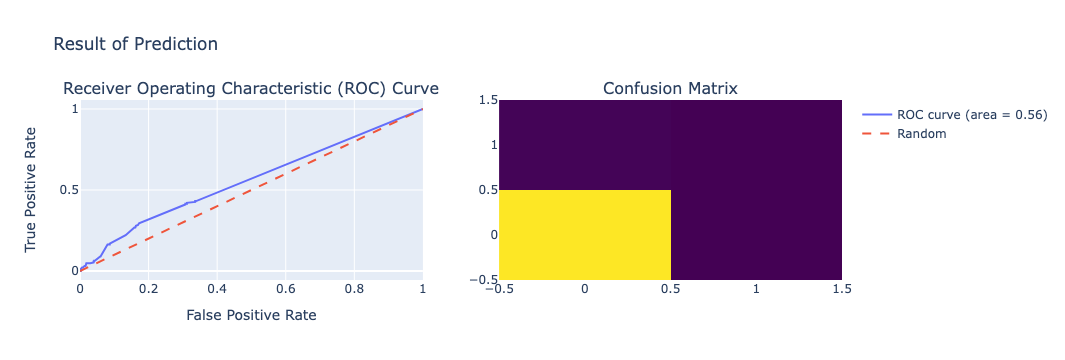

In [79]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import plotly.graph_objects as go
from plotly.subplots import make_subplots


# Calculate the ROC curve
y_true = test_data['controversiality']
y_scores = rf_clf.predict_proba(test_data['clean_body'])[:, 1]  # Probability of class 1

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, predictions_rf)

# Plot ROC Curve and Confusion Matrix with Plotly
fig = make_subplots(rows=1, cols=2, subplot_titles=['Receiver Operating Characteristic (ROC) Curve', 'Confusion Matrix'])

# ROC Curve
fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name='ROC curve (area = {:.2f})'.format(roc_auc)),
              row=1, col=1)
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Random', line=dict(dash='dash')),
              row=1, col=1)
fig.update_xaxes(title_text='False Positive Rate', row=1, col=1)
fig.update_yaxes(title_text='True Positive Rate', row=1, col=1)

# Confusion Matrix
fig.add_trace(go.Heatmap(z=conf_matrix, colorscale='Viridis', showscale=False),
              row=1, col=2)
fig.update_layout(title_text=' Result of Prediction ')

# Save the combined figure
save_path = '/root/fall-2023-reddit-project-team-33/data/plots/RF_ROC_ConfusionMatrix.html'
fig.write_html(save_path)
fig.show()

## Confusion Matrix and ROC Curve Analysis

This Three models exhibit impressive accuracy of 0.99, primarily driven by its ability to accurately predict instances of the majority class (class 0, non-controversial). However, a deeper analysis through the confusion matrix and ROC curve reveals significant challenges in correctly identifying instances of the minority class (class 1, controversial). The confusion matrix indicates that the model has failed to predict any true positives for the controversial class, resulting in a lack of precision, recall, and F1-score for class 1. The ROC curve, characterized by a diagonal line and an AUC of 0.5, further underscores the model's struggle to discriminate effectively between the two classes. These findings suggest a need for addressing class imbalance and potentially exploring alternative models or parameter tuning to enhance the Random Forest's performance, especially in capturing patterns related to the controversial class.

In summary, while the overall accuracy appears impressive, the model's inability to correctly identify instances of the minority class is a significant limitation. Further refinement, potentially involving class rebalancing techniques or alternative modeling approaches, is recommended to ensure a more balanced and effective predictive performance across both classes in real-world applications.

# Controversiality Text Classification Summary

The Controversiality text classification model did a great job overall, achieving a super high accuracy of 99%! However, when we take a closer look, there's a bit more to the story.

## Breakdown:

### Great at Easy Questions (Non-controversial):

- The model aced the questions related to everyday, non-controversial topics. It got 99% of those right!
- It's like the student getting almost every question about everyday life correct.

### Struggling with Difficult Questions (Controversial):

- Now, when it comes to the tricky questions about controversial issues, the model kind of drew a blank. It didn't get a single one right!
- It's like the student completely missing all the challenging questions on controversial topics.

### Overall Grade:

- If we calculate the overall grade for the test, it looks fantastic because the majority of the questions were easy. The model got an A+!
- However, if we look closer and see how the student performed on the tough questions, it's not so great.

## In a Nutshell:

- The model is like a superstar when it comes to everyday stuff but needs some serious help understanding controversial topics.
- So, while the overall grade looks impressive, it's important to remember that there's room for improvement, especially in dealing with the more challenging, controversial aspects.

## Suggestions for Improvement:

- It might be helpful to give the model more exposure to controversial topics during training, like giving our student more practice with the tougher questions.
- The model could benefit from learning different strategies to handle these tricky topics, maybe by considering more factors or using a more sophisticated approach.
- Also, we could try to balance the topics in our test to make sure we're not just testing on the easy stuff.

In a nutshell, while the model is a star in some areas, it still has some homework to do when it comes to understanding controversial issues.


## Improvement

### Get Balanced Comments Datasets

In summary, without a balanced dataset, the models achieved an impressive 99% accuracy in predicting 'controversiality=False'. However, when it comes to predicting 'controversiality=True' comments, the performance is less satisfactory. Therefore, we started from the original dataset, ensuring a total data length not exceeding 10,000. We randomly sampled and merged from the original 834,339 records with 'controversiality=False' and 8,563 records with 'controversiality=True'. Subsequently, we cleaned the text content in the balanced dataset and utilized logistic regression, Naive Bayes, and SVM for prediction. This approach aims to address the imbalanced class issue and enhance the models' performance.

In [6]:
comments.show(5)

+--------------------+--------------+----------------------+-----------------+--------------------+--------+----------------+-------------------+-------------+------+------+-------+------------+---------+----------+--------------------+-------------------+-----+--------+---------------+------------+
|              author|author_cakeday|author_flair_css_class|author_flair_text|                body|can_gild|controversiality|        created_utc|distinguished|edited|gilded|     id|is_submitter|  link_id| parent_id|           permalink|       retrieved_on|score|stickied|      subreddit|subreddit_id|
+--------------------+--------------+----------------------+-----------------+--------------------+--------+----------------+-------------------+-------------+------+------+-------+------------+---------+----------+--------------------+-------------------+-----+--------+---------------+------------+
|        chinghiskhan|          null|                00FFFF|       Glitterati|  Aww, thank you! 💙

In [12]:
#### sample the improve_comments dataset
improve_comments = comments.sample(withReplacement=False, fraction=0.8, seed=123)

In [13]:


from pyspark.sql.types import IntegerType

# Convert 'controversiality' to integer type (assuming it's not already)
improve_comments = improve_comments.withColumn('controversiality', improve_comments['controversiality'].cast(IntegerType()))

# Convert 'controversiality' to a categorical variable
improve_comments = improve_comments.withColumn('controversiality', improve_comments['controversiality'].cast('string'))

# Show the updated DataFrame

improve_comments_selected = improve_comments.select('body', 'controversiality')



In [ ]:

controversiality_counts = improve_comments_selected.groupBy('controversiality').count()

# Show the count of different controversiality values
controversiality_counts.show()


+----------------+------+
|controversiality| count|
+----------------+------+
|               0|834339|
|               1|  8563|
+----------------+------+



In [14]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import rand

# Randomly sample 8343 records from samples with controversiality=0
controversiality_0_samples = improve_comments.filter(improve_comments['controversiality'] == 0).orderBy(rand(seed=42)).limit(8343)

# Select all 8563 records from samples with controversiality=1
controversiality_1_samples = improve_comments.filter(improve_comments['controversiality'] == 1)

# Merge the two subsets
balanced_df = controversiality_0_samples.union(controversiality_1_samples)

# Randomly sample 10000 records
balanced_df = balanced_df.orderBy(rand(seed=42)).limit(10000)

# Display the results
balanced_df.show()


+--------------------+--------------+----------------------+-----------------+--------------------+--------+----------------+-------------------+-------------+------+------+-------+------------+----------+----------+--------------------+-------------------+-----+--------+---------------+------------+
|              author|author_cakeday|author_flair_css_class|author_flair_text|                body|can_gild|controversiality|        created_utc|distinguished|edited|gilded|     id|is_submitter|   link_id| parent_id|           permalink|       retrieved_on|score|stickied|      subreddit|subreddit_id|
+--------------------+--------------+----------------------+-----------------+--------------------+--------+----------------+-------------------+-------------+------+------+-------+------------+----------+----------+--------------------+-------------------+-----+--------+---------------+------------+
|         teatalker26|          null|                  null|             null|          no tha

In [16]:
from pyspark.sql.functions import col, regexp_replace, lower
from pyspark.sql import SparkSession
from pyspark.sql.functions import lower, col, regexp_replace, udf, length, StringType
from pyspark.ml.feature import Tokenizer, StopWordsRemover
balanced_df = balanced_df.withColumn('clean_body', clean_text_udf(col('body')))
balanced_df = balanced_df.na.drop(subset=["clean_body"])
balanced_df = balanced_df.filter(length(col('clean_body')) > 0)


In [17]:
Contro_dataset=balanced_df.select("clean_body","controversiality")


In [18]:
Contro_dataset=Contro_dataset.toPandas()

  

In [91]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import rand
from sklearn.model_selection import train_test_split

# Split the data into features (X) and labels (y)
X = Contro_dataset['clean_body'].tolist()  # Convert to a list
y = Contro_dataset['controversiality'].tolist()  # Convert to a list

# Split the data into training and testing sets
# Adjust the test_size parameter to control the ratio of the split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Now  can use X_train and y_train for training your model
# And X_test and y_test for evaluating the model


train_data = pd.DataFrame({'clean_body': X_train, 'controversiality': y_train})
test_data = pd.DataFrame({'clean_body': X_test, 'controversiality': y_test})



In [16]:



# Import necessary libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score

# Step 1: Create a pipeline with a TF-IDF vectorizer and a classifier (e.g., Naive Bayes)
text_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

# Step 2: Train the model on the training data
text_clf.fit(train_data['clean_body'], train_data['controversiality'])

# Step 3: Make predictions on the test data
predictions = text_clf.predict(test_data['clean_body'])

# Step 4: Evaluate the model performance
accuracy = accuracy_score(test_data['controversiality'], predictions)
print(f"Accuracy: {accuracy:.2f}")

#  print a classification report for more detailed metrics
print(classification_report(test_data['controversiality'], predictions))



Accuracy: 0.67
              precision    recall  f1-score   support

           0       0.74      0.56      0.63      1014
           1       0.63      0.79      0.70       965

    accuracy                           0.67      1979
   macro avg       0.68      0.67      0.67      1979
weighted avg       0.68      0.67      0.67      1979



In [17]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', RandomForestClassifier())
])

rf_clf.fit(train_data['clean_body'], train_data['controversiality'])
predictions_rf = rf_clf.predict(test_data['clean_body'])

accuracy_rf = accuracy_score(test_data['controversiality'], predictions_rf)
print(f"Random Forest Accuracy: {accuracy_rf:.2f}")
print(classification_report(test_data['controversiality'], predictions_rf))


Random Forest Accuracy: 0.65
              precision    recall  f1-score   support

           0       0.68      0.58      0.63      1014
           1       0.62      0.71      0.66       965

    accuracy                           0.65      1979
   macro avg       0.65      0.65      0.65      1979
weighted avg       0.65      0.65      0.65      1979



In [18]:
from sklearn.svm import SVC

svm_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', SVC())
])

svm_clf.fit(train_data['clean_body'], train_data['controversiality'])
predictions_svm = svm_clf.predict(test_data['clean_body'])

accuracy_svm = accuracy_score(test_data['controversiality'], predictions_svm)
print(f"SVM Accuracy: {accuracy_svm:.2f}")
print(classification_report(test_data['controversiality'], predictions_svm))


SVM Accuracy: 0.67
              precision    recall  f1-score   support

           0       0.72      0.59      0.65      1014
           1       0.64      0.76      0.70       965

    accuracy                           0.67      1979
   macro avg       0.68      0.68      0.67      1979
weighted avg       0.68      0.67      0.67      1979



### Tuning

### MultinomialNB

In [20]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import accuracy_score, classification_report

# Custom text preprocessor function
def custom_preprocessor(text):
    # Your custom preprocessing logic here
    return preprocessed_text

# Define the pipeline with placeholders for hyperparameters
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

# Define the hyperparameters to search
parameters = {
    'tfidf__max_df': (0.5, 0.75, 1.0),
    'tfidf__min_df': (1, 2, 5),
    'tfidf__ngram_range': ((1, 1), (1, 2)),
    'clf__alpha': (1e-2, 1e-3, 1e-4),
    'clf__fit_prior': [True, False],
    'tfidf__max_features': [None, 5000, 10000, 20000],
}

# Use GridSearchCV to find the best combination of hyperparameters
grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, verbose=1, scoring='accuracy')
grid_search.fit(train_data['clean_body'], train_data['controversiality'])

# Print the best hyperparameters
print("Best Hyperparameters:")
print(grid_search.best_params_)

# Perform nested cross-validation
nested_cv_scores = cross_val_score(grid_search, train_data['clean_body'], train_data['controversiality'], cv=5, scoring='accuracy')
print("Nested Cross-Validation Accuracy: {:.2f} (+/- {:.2f})".format(nested_cv_scores.mean(), nested_cv_scores.std() * 2))

# Train the model with the best hyperparameters on the entire training set
best_model = grid_search.best_estimator_
best_model.fit(train_data['clean_body'], train_data['controversiality'])

# Make predictions on the test set using the best model
best_predictions = best_model.predict(test_data['clean_body'])

# Evaluate the performance of the best model
best_accuracy = accuracy_score(test_data['controversiality'], best_predictions)
print(f"Best Model Accuracy: {best_accuracy:.2f}")

# Print a classification report for the best model
print("Classification Report for Best Model:")
print(classification_report(test_data['controversiality'], best_predictions))


Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best Hyperparameters:
{'clf__alpha': 0.001, 'clf__fit_prior': True, 'tfidf__max_df': 0.5, 'tfidf__max_features': 5000, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 1)}
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Nested Cross-Validation Accuracy: 0.65 (+/- 0.03)
Best Model Accuracy: 0.66
Classification Report for Best Model:
              precision    recall  f1-score   support

           0       0.75      0.50      0.60      1014
           1       0.61      0.83      0.70       965

    accuracy                           0.66      1979
   macro avg       0.68      0.66      0.65      1979
weighted avg       0.68      0.66      0.65      1979



The machine learning model was fine-tuned using nested cross-validation, resulting in the best hyperparameters. The model achieved an overall accuracy of 66%, with specific settings favoring recall for class 1. While the precision and recall for class 0 were 75% and 50%, respectively, class 1 showed better performance with 61% precision and 83% recall. The model's F1-score, a balance between precision and recall, was 65%. Overall, there's room for improvement, particularly in correctly identifying instances of class 0.

### RandomForest 

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

# Define the pipeline
rf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', RandomForestClassifier())
])

# Define hyperparameters to search
rf_parameters = {
    'tfidf__max_df': (0.75, 1.0),
    'tfidf__min_df': (2, 5),
    'tfidf__ngram_range': ((1, 1), (1, 2)),
    'tfidf__max_features': [5000, 10000],
    'clf__n_estimators': [50,100, 200],
    'clf__max_depth': [10, 20],
    'clf__min_samples_split': [5, 10],
    'clf__min_samples_leaf': [2, 4],
   
}

# Use GridSearchCV to find the best combination of hyperparameters
rf_grid_search = GridSearchCV(rf_pipeline, rf_parameters, cv=5, n_jobs=-1, verbose=1)
rf_grid_search.fit(train_data['clean_body'], train_data['controversiality'])

# Print the best hyperparameters
print("Best Random Forest Hyperparameters:")
print(rf_grid_search.best_params_)

# Train the best model on the entire training set
best_rf_model = rf_grid_search.best_estimator_
best_rf_model.fit(train_data['clean_body'], train_data['controversiality'])

# Evaluate model performance
best_predictions_rf = best_rf_model.predict(test_data['clean_body'])
best_accuracy_rf = accuracy_score(test_data['controversiality'], best_predictions_rf)
print(f"Best Random Forest Model Accuracy: {best_accuracy_rf:.2f}")

# Print a classification report
print("Classification Report for Best Random Forest Model:")
print(classification_report(test_data['controversiality'], best_predictions_rf))


Fitting 5 folds for each of 384 candidates, totalling 1920 fits
Best Random Forest Hyperparameters:
{'clf__max_depth': 20, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 10, 'clf__n_estimators': 200, 'tfidf__max_df': 1.0, 'tfidf__max_features': 10000, 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 1)}
Best Random Forest Model Accuracy: 0.66
Classification Report for Best Random Forest Model:
              precision    recall  f1-score   support

           0       0.77      0.49      0.60      1014
           1       0.61      0.84      0.71       965

    accuracy                           0.66      1979
   macro avg       0.69      0.67      0.65      1979
weighted avg       0.69      0.66      0.65      1979



The random forest model was optimized with hyperparameter tuning, resulting in the best configuration: max_depth of 20, min_samples_leaf of 2, min_samples_split of 10, and 200 estimators. Additionally, TF-IDF vectorizer settings were identified as follows: max_df of 1.0, max_features of 10,000, min_df of 5, and ngram_range of (1, 1). The model achieved an accuracy of 66%.

Breaking down the classification report for the best random forest model, precision for class 0 was 77%, with a recall of 49% and an F1-score of 60%. For class 1, precision was 61%, recall was 84%, and the F1-score was 71%. The macro-average F1-score was 65%. In summary, the model performed reasonably well, particularly in correctly identifying instances of class 1. However, there's room for improvement, especially in enhancing recall for class 0.

### SVM

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

# Define the pipeline
svm_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', SVC())
])

# Define hyperparameters to search
svm_parameters = {
    'tfidf__max_df': [0.5, 0.75, 1.0],
    'tfidf__min_df': [1, 2, 5],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'clf__C': [0.1, 1, 10],
    'clf__kernel': ['linear', 'rbf'],
    'clf__gamma': ['scale', 'auto'],
}

# Use GridSearchCV to find the best hyperparameters
svm_grid_search = GridSearchCV(svm_pipeline, svm_parameters, cv=5, n_jobs=-1, verbose=1)
svm_grid_search.fit(train_data['clean_body'], train_data['controversiality'])

# Print the best hyperparameters
print("Best SVM Hyperparameters:")
print(svm_grid_search.best_params_)

# Train the best model on the entire training set
best_svm_model = svm_grid_search.best_estimator_
best_svm_model.fit(train_data['clean_body'], train_data['controversiality'])

# Evaluate model performance
best_predictions_svm = best_svm_model.predict(test_data['clean_body'])
best_accuracy_svm = accuracy_score(test_data['controversiality'], best_predictions_svm)
print(f"Best SVM Model Accuracy: {best_accuracy_svm:.2f}")

# Print a classification report
print("Classification Report for Best SVM Model:")
print(classification_report(test_data['controversiality'], best_predictions_svm))


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best SVM Hyperparameters:
{'clf__C': 1, 'clf__gamma': 'scale', 'clf__kernel': 'rbf', 'tfidf__max_df': 0.5, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 1)}
Best SVM Model Accuracy: 0.67
Classification Report for Best SVM Model:
              precision    recall  f1-score   support

           0       0.72      0.59      0.65      1014
           1       0.64      0.76      0.70       965

    accuracy                           0.67      1979
   macro avg       0.68      0.68      0.67      1979
weighted avg       0.68      0.67      0.67      1979



### Save the Best Model

In [ ]:

import joblib



# Save the best SVM model to a file
model_save_path = '/root/fall-2023-reddit-project-team-33/code/best_svm_model.joblib'
joblib.dump(best_svm_model, model_save_path)

print(f"Best SVM model saved to {model_save_path}")

### Load the best model

In [92]:
import joblib

# Load the saved SVM model from the file
best_svm_model = joblib.load('/root/fall-2023-reddit-project-team-33/code/ML/best_svm_model.joblib')



In [93]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

# Evaluate model performance
best_predictions_svm = best_svm_model.predict(test_data['clean_body'])
best_accuracy_svm = accuracy_score(test_data['controversiality'], best_predictions_svm)
print(f"Best SVM Model Accuracy: {best_accuracy_svm:.2f}")

# Print a classification report
print("Classification Report for Best SVM Model:")
print(classification_report(test_data['controversiality'], best_predictions_svm))


Best SVM Model Accuracy: 0.67
Classification Report for Best SVM Model:
              precision    recall  f1-score   support

           0       0.72      0.59      0.65      1014
           1       0.64      0.76      0.70       965

    accuracy                           0.67      1979
   macro avg       0.68      0.68      0.67      1979
weighted avg       0.68      0.67      0.67      1979



In [94]:
cm = confusion_matrix(test_data['controversiality'], best_predictions_svm)


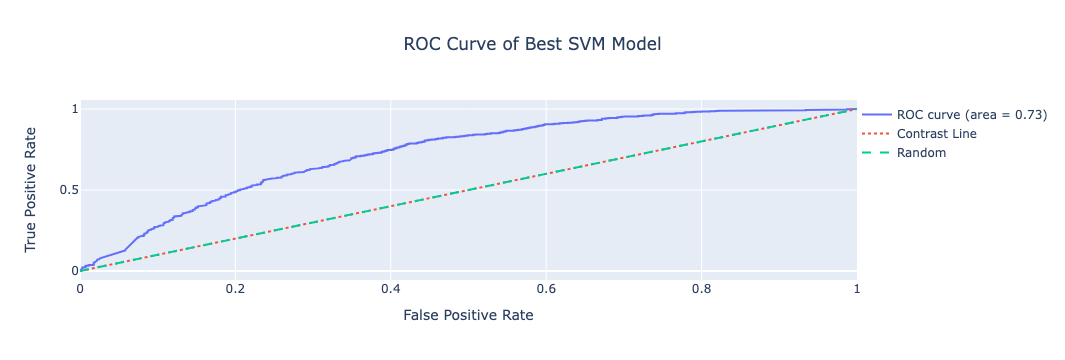

In [96]:
import plotly.graph_objects as go
from sklearn.metrics import roc_curve, auc

#test_data and best_svm_model are defined

# Convert string labels to numerical format
test_data['controversiality'] = test_data['controversiality'].astype(int)

# Function to plot ROC curve using Plotly
def plot_roc_curve_plotly(y_true, y_scores, subplot_title):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # Compute the contrast line (diagonal line)
    contrast_line_x = [0, 1]
    contrast_line_y = [0, 1]

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name=f'ROC curve (area = {roc_auc:.2f})'))
    fig.add_trace(go.Scatter(x=contrast_line_x, y=contrast_line_y, mode='lines', name='Contrast Line', line={'dash': 'dot'}))
    fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Random', line={'dash': 'dash'}))
    
    fig.update_layout(
        title=f'Receiver Operating Characteristic (ROC) Curve - {subplot_title}',
        xaxis=dict(title='False Positive Rate'),
        yaxis=dict(title='True Positive Rate'),
        showlegend=True,
    )

    return fig

# Get the predicted scores for the positive class
y_scores_svm = best_svm_model.decision_function(test_data['clean_body'])

# Create ROC curve using Plotly
roc_fig = plot_roc_curve_plotly(test_data['controversiality'], y_scores_svm, 'SVM')

# Update layout for the figure
roc_fig.update_layout(
    title_text='ROC Curve of Best SVM Model',
    title_x=0.5,  # Center the title
    legend=dict(x=1, y=1),  # Adjust legend position for the ROC curve subplot
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
)

# Save the ROC curve plot as an HTML file
save_path = '/root/fall-2023-reddit-project-team-33/data/plots/BestSVM_ROC.html'
roc_fig.write_html(save_path)

roc_fig.show()

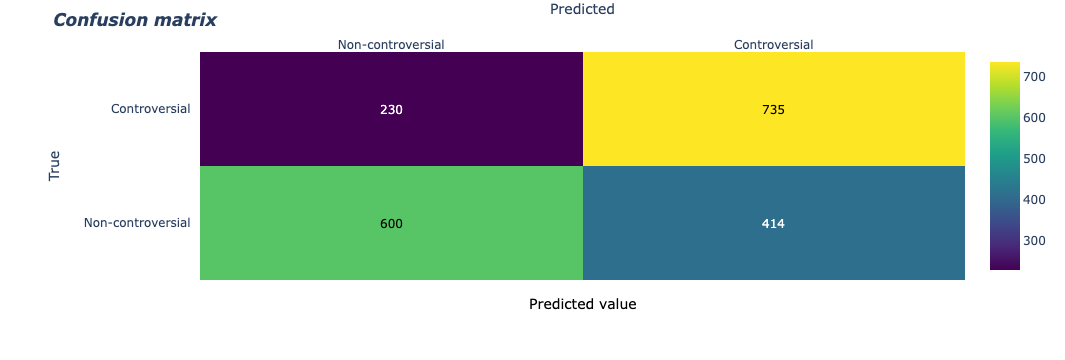

In [103]:

def plot_confusion_matrix_plotly(y_true, y_pred, subplot_title):
    cm = confusion_matrix(y_true, y_pred).tolist() # Normalizing the confusion matrix

    x_labels = ['Non-controversial', 'Controversial']
    y_labels = ['Non-controversial', 'Controversial']
    
    z_text = [[str(value) for value in row] for row in cm]

    fig = ff.create_annotated_heatmap(z=cm, x=x_labels, y=y_labels,  annotation_text=z_text,colorscale='Viridis')

    fig.update_layout(
        title=f'Confusion Matrix - {subplot_title}',
        xaxis=dict(title='Predicted'),
        yaxis=dict(title='True'),
    )
    # add title
    fig.update_layout(title_text='<i><b>Confusion matrix</b></i>',
                  #xaxis = dict(title='x'),
                  #yaxis = dict(title='x')
                 )
    fig.add_annotation(dict(font=dict(color="black",size=14),
                        x=0.5,
                        y=-0.15,
                        showarrow=False,
                        text="Predicted value",
                        xref="paper",
                        yref="paper"))
    fig.add_annotation(dict(font=dict(color="black",size=14),
                        x=-0.35,
                        y=0.5,
                        showarrow=False,
                        text="Real value",
                        textangle=-90,
                        xref="paper",
                        yref="paper"))
    fig.update_layout(margin=dict(t=50, l=200))
    fig['data'][0]['showscale'] = True
    fig.show()

    return fig

cm_fig=plot_confusion_matrix_plotly(test_data['controversiality'], y_pred_svm, 'SVM')
save_path_cm = '/root/fall-2023-reddit-project-team-33/data/plots/BestSVM_ConfusionMatrix.html'
cm_fig.write_html(save_path_cm)


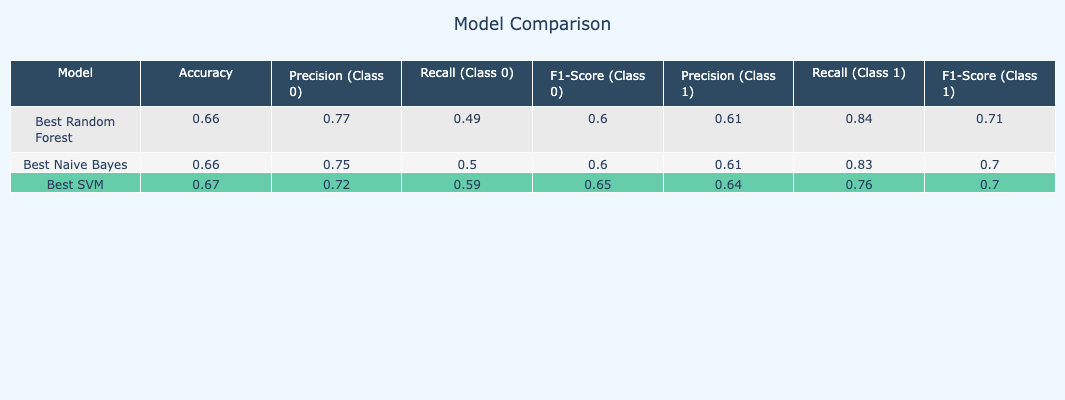

In [119]:

import plotly.graph_objects as go

# Data for the table
models = ['Best Random Forest', 'Best Naive Bayes', 'Best SVM']
accuracies = [0.66, 0.66, 0.67]
precision_0 = [0.77, 0.75, 0.72]
recall_0 = [0.49, 0.50, 0.59]
f1_0 = [0.60, 0.60, 0.65]
precision_1 = [0.61, 0.61, 0.64]
recall_1 = [0.84, 0.83, 0.76]
f1_1 = [0.71, 0.70, 0.70]

# Find the index corresponding to 'Best SVM' model
svm_index = models.index('Best SVM')

# Create a list to hold the row colors
row_colors = ['#EAEAEA', '#F5F5F5', '#EAEAEA']  # Example colors, feel free to customize

# Update the color for the 'Best SVM' row
row_colors[svm_index] = '#66CDAA'  # Highlight color for 'Best SVM' row

# Create a table
fig = go.Figure(data=[go.Table(
    header=dict(values=['Model', 'Accuracy', 'Precision (Class 0)', 'Recall (Class 0)', 'F1-Score (Class 0)',
                         'Precision (Class 1)', 'Recall (Class 1)', 'F1-Score (Class 1)'],
                fill_color='#2E4A62',  # Header color
                font=dict(color='white')),  # Font color for header
    cells=dict(values=[models, accuracies, precision_0, recall_0, f1_0, precision_1, recall_1, f1_1],
               fill_color=[row_colors]*len(models),  # Use row_colors for each row
               align='center'))  # Center-align cell content
])

# JavaScript code for hover effect
hover_code = '''
<script>
    var table = document.getElementById("trace_0");
    for (var i = 0; i < table.rows.length; i++) {
        table.rows[i].onmouseover = function () {
            this.style.backgroundColor = '#ADD8E6';
        };
        table.rows[i].onmouseout = function () {
            this.style.backgroundColor = '';
        };
    }
</script>
'''

# Update the layout for better readability
fig.update_layout(title_text='Model Comparison',
                  title_x=0.5,
                  width=800,
                  height=400,
                  margin=dict(l=10, r=10, b=10, t=60),  # Adjust margins for better layout
                  paper_bgcolor='#F0F8FF',  # Background color
                  plot_bgcolor='#F0F8FF')  # Plot area color

# Save the figure as an HTML file with additional JavaScript code
with open("/root/fall-2023-reddit-project-team-33/data/plots/model_comparison.html", "w") as file:
    file.write(fig.to_html() + hover_code)

fig.show()





We performed parameter tuning for logistic regression, SVM, and Naive Bayes. However, we observed that the overall predictive performance did not show significant improvement compared to the results before parameter adjustment. The accuracy has been maintained at around 0.67.Therefore, we select the Best SVM model as the Best model overall. Because The accuracy show the smallest different between two classes.

Why SVM is Chosen as the Best Model:

Overall Accuracy: SVM has the highest overall accuracy (0.67), indicating better overall performance in making correct predictions.

Class 1 Performance: SVM shows competitive or superior precision, recall, and F1-score for predicting instances of Class 1 compared to other models.

Class 0 Performance: Similar positive performance trends are observed for predicting instances of Class 0.

Consideration of Metrics: The choice depends on the specific goals; SVM is selected based on a balance of precision, recall, and F1-score.

Domain Relevance: Depending on the application, certain metrics may be more crucial. Consider the consequences of false positives and false negatives in your context.

Cross-Validation: Ensure consistent performance across different datasets, as the table may represent results for a specific dataset.

In summary, SVM emerges as the preferred model due to its higher overall accuracy and competitive performance in key metrics, making it well-suited for the specific objectives of the project.








 ### Understanding the Best Model:
We've used fancy techniques to find the best settings for our model, and it turns out that the best version uses certain numbers and settings. The model, which is like a smart tool, got a score of 67 out of 100 in how well it does its job.

### Checking How Good it Is:
We looked at how well the tool does for different kinds of comments. For regular comments, it's about 72% correct, but it misses some (about 59%). For tricky comments, it's about 64% correct, but it's better at finding most of them (about 76%).

### What it Means for Our Goal:
Our goal was to spot comments that might cause a fuss. The tool is a bit better at finding these kinds of comments, especially the tricky ones. So, it can help us keep an eye on discussions that might get people talking or arguing.

### How We Can Use It:
**Helping Keep Things Nice:** We can use the tool to help check comments automatically and find ones that might need a closer look. This way, we keep the conversation friendly and positive.

**Learning What People Like:** By looking at tricky comments, we can learn more about what people are interested in or care about. This helps us make the platform more interesting for everyone.

**Avoiding Problems:** Spotting tricky comments early can help us avoid problems before they happen. It's like having a friend who tells us when something might not be going well.

**Checking and Improving:** We'll keep an eye on how well the tool is doing and make it even better over time. Just like apps get updates on your phone, our tool will get smarter to keep up with how people talk.

*Remember, while the tool is helpful, it's not perfect. We still need real people to make the final decisions, especially when things are a bit tricky or sensitive. Combining the tool with human judgment helps us make sure everything goes smoothly on our platform.*
